# Numerical experiments: GPQ using PBK on low-order polynomials

This notebook refers to Section 5.2 of the Bachelorthesis.

## Low-order monomial quadrature

We will now integrate low-order monomials $x^t + 1,\;t=0,\ldots,10$ with the Polynomial Basis kernel and GPQ. For the weight we will choose a variety of parameters $b$ and test which parameters $b$ results in the best approximations.

In [1]:
import numpy as np
import scipy as sp
import GPy
import kernels
import functions
from matplotlib import pyplot as plt

In [2]:
b = np.array([0.1, 0.5, 0.9])
number_of_powers = 16
integralvalues = np.zeros((6, number_of_powers + 1, len(b)))
variancevalues = np.zeros((6, number_of_powers + 1, len(b)))
I_exact = np.zeros(number_of_powers + 1)
for k in range(2, 8):
    for i in range(0, len(b)):
        PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
        for t in range(0, number_of_powers + 1):
            def func(x):
                return np.power(x, t) + 1
            X = functions.GPQ(f=func, kernel=PBK, A=np.array([-1, 1]), NoN=k, return_var=True)
            integralvalues[k-2][t][i] = X[0]
            variancevalues[k-2][t][i] = X[1]
            if i == 0 and k == 2:
                I_exact[t] = sp.integrate.quad(func, a=-1, b=1, epsabs=1.49e-16)[0]

In [3]:
abs_err = np.zeros((6, number_of_powers + 1, len(b)))
rel_err = np.zeros((6, number_of_powers + 1, len(b)))
for k in range(2, 8):
    for i in range(0, len(b)):
        for t in range(0, number_of_powers + 1):
            abs_err[k-2][t][i] = np.absolute(integralvalues[k-2][t][i]- I_exact[t])
            rel_err[k-2][t][i] = np.absolute(abs_err[k-2][t][i]) / np.absolute(integralvalues[k-2][t][i])

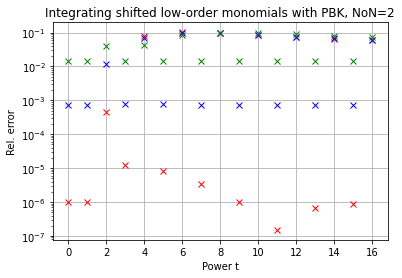

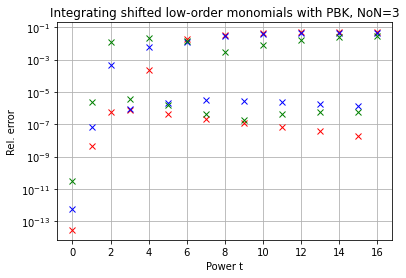

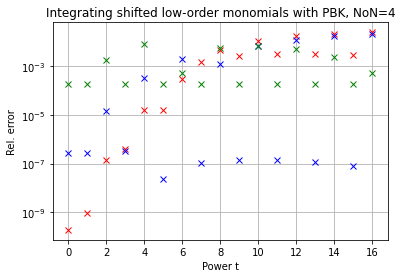

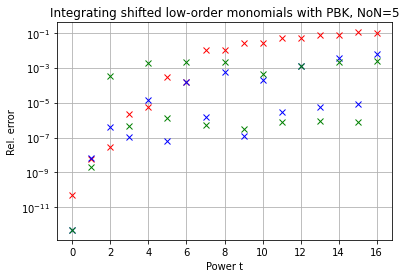

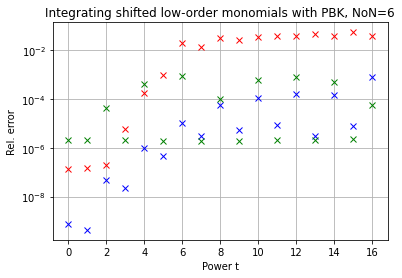

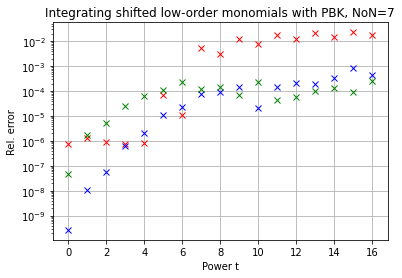

In [20]:
X = np.arange(0, number_of_powers + 1)
for k in range(2, 8):
    plt.figure()
    plt.grid()
    plt.plot(X, rel_err[k-2].T[0], 'rx', label='$b=0.1$')
    plt.plot(X, rel_err[k-2].T[1], 'bx', label='$b=0.5$')
    plt.plot(X, rel_err[k-2].T[2], 'gx', label='$b=0.9$')
    plt.yscale('log')
    plt.xlabel('Power t')
    plt.ylabel('Rel. error')
    plt.title('Integrating shifted low-order monomials with PBK, NoN=' + '{}'.format(k))
    #plt.legend()
    plt.show()

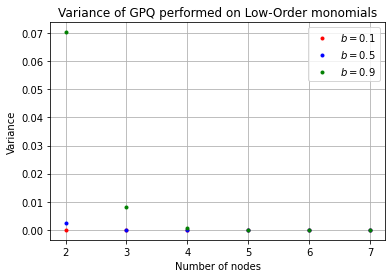

In [22]:
X1 = np.arange(2, 8)
vvalues = np.zeros((3, 6))
for i in range(0, 3):
    for j in range(0, 6):
        vvalues.T[i] = variancevalues[i][j]
plt.figure()
plt.grid()
#plt.yscale('log')
plt.plot(X1, vvalues[0], 'r.', label='$b=0.1$')
plt.plot(X1, vvalues[1], 'b.', label='$b=0.5$')
plt.plot(X1, vvalues[2], 'g.', label='$b=0.9$')
    
plt.xlabel('Number of nodes')
plt.ylabel('Variance')
plt.title('Variance of GPQ performed on Low-Order monomials')
plt.legend()
plt.show()

For the variance spectrum we get:

In [6]:
np.max(np.absolute(variancevalues))

0.07026918982828256

In [7]:
np.min(np.absolute(variancevalues))

4.881428594671888e-12

## Low-order polynomial quadrature

In this section we will have a look at linear combinations of the previous monomials and random coefficients.

In [8]:
rng = np.random.default_rng(420)
length = rng.integers(low=1, high=16, size=1)
coeff = rng.random((length[0],))

In [9]:
def poly(x):
    temp = 0
    for i in range(0, len(coeff)):
        temp = temp + coeff[i] * np.power(x, i)
    return temp

Here is a plot of the random polynomial:

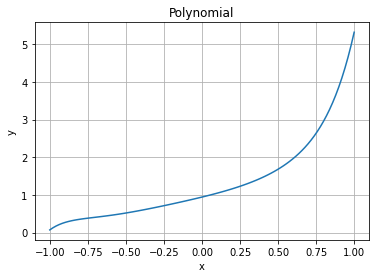

In [10]:
X = np.linspace(-1, 1, 100)
Y = poly(X)
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial')
plt.grid()
plt.plot(X, Y)
plt.show()

Now we will perform quadrature with $n=2, 3, 4, 5, 6$ and $7$ nodes. Again we will have the parameter $b$ to be in $\{0.1, 0.5, 0.9\}$.

In [11]:
integralvalues_poly = np.zeros((6, len(b)))
variancevalues_poly = np.zeros((6, len(b)))
abs_err_poly = np.zeros((6, len(b)))
rel_err_poly = np.zeros((6, len(b)))
I_exact_poly = sp.integrate.quad(poly, a=-1, b=1, epsabs=1.49e-16)[0]

for k in range(2, 8):
    for i in range(0, len(b)):
        PBK = kernels.PolynomialBasis(input_dim=1, weight=b[i])
        GPQ = functions.GPQ(f=poly, kernel=PBK, A=np.array([-1, 1]), NoN=k, return_var=True)
        integralvalues_poly[k-2][i] = GPQ[0]
        variancevalues_poly[k-2][i] = GPQ[1]
        abs_err_poly[k-2][i] = np.absolute(integralvalues_poly[k-2][i]- I_exact_poly)
        rel_err_poly[k-2][i] = abs_err_poly[k-2][i] / np.absolute(I_exact_poly)

The approximated exact solution:

In [12]:
I_exact_poly

2.626713761525368

Plotting the results as a probability distribution:

In [13]:
'''
for k in range(2, 8):
    for i in range(0, len(b)):
        X = np.linspace(integralvalues_poly[k-2][i]-3*variancevalues_poly[k-2][i], integralvalues_poly[k-2][i]+3*variancevalues_poly[k-2][i], 100)
        def prob(x):
            prob_density = (np.pi*variancevalues_poly[k-2][i]) * np.exp(-0.5*((x-integralvalues_poly[k-2][i])/variancevalues_poly[k-2][i])**2)
            return prob_density
        p = prob(X)
        fp = prob(integralvalues_poly[k-2][i])
        plt.figure()
        plt.grid()
        plt.vlines(integralvalues_poly[k-2][i], ymin=0, ymax=fp, colors='g')
        plt.plot(X, p)
        plt.show()
'''

"\nfor k in range(2, 8):\n    for i in range(0, len(b)):\n        X = np.linspace(integralvalues_poly[k-2][i]-3*variancevalues_poly[k-2][i], integralvalues_poly[k-2][i]+3*variancevalues_poly[k-2][i], 100)\n        def prob(x):\n            prob_density = (np.pi*variancevalues_poly[k-2][i]) * np.exp(-0.5*((x-integralvalues_poly[k-2][i])/variancevalues_poly[k-2][i])**2)\n            return prob_density\n        p = prob(X)\n        fp = prob(integralvalues_poly[k-2][i])\n        plt.figure()\n        plt.grid()\n        plt.vlines(integralvalues_poly[k-2][i], ymin=0, ymax=fp, colors='g')\n        plt.plot(X, p)\n        plt.show()\n"

Plotting of the absolute error and relative error:

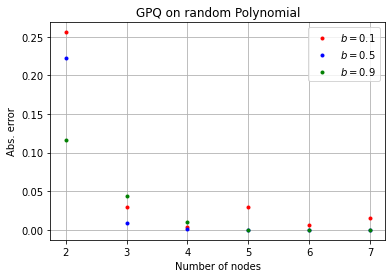

In [14]:
X = np.arange(2, 8)
plt.figure()
plt.grid()
plt.plot(X, abs_err_poly.T[0], 'r.', label='$b=0.1$')
plt.plot(X, abs_err_poly.T[1], 'b.', label='$b=0.5$')
plt.plot(X, abs_err_poly.T[2], 'g.', label='$b=0.9$')
plt.xlabel('Number of nodes')
plt.legend()
plt.ylabel('Abs. error')
plt.title('GPQ on random Polynomial')
plt.show()

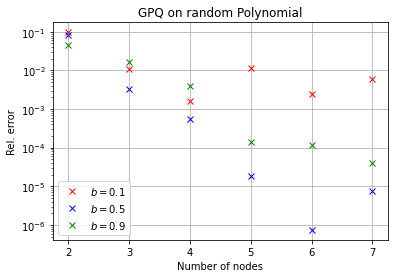

In [25]:
X = np.arange(2, 8)
plt.figure()
plt.grid()
plt.plot(X, rel_err_poly.T[0], 'rx', label='$b=0.1$')
plt.plot(X, rel_err_poly.T[1], 'bx', label='$b=0.5$')
plt.plot(X, rel_err_poly.T[2], 'gx', label='$b=0.9$')
plt.xlabel('Number of nodes')
plt.yscale('Log')
plt.legend()
plt.ylabel('Rel. error')
plt.title('GPQ on random Polynomial')
plt.show()

Plotting the variances of the GPQ:

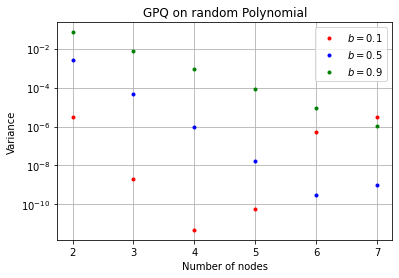

In [16]:
plt.figure()
plt.grid()
plt.plot(X, np.absolute(variancevalues_poly.T[0]), 'r.', label='$b=0.1$')
plt.plot(X, variancevalues_poly.T[1], 'b.', label='$b=0.5$')
plt.plot(X, variancevalues_poly.T[2], 'g.', label='$b=0.9$')
plt.xlabel('Number of nodes')
plt.yscale('log')
plt.legend()
plt.ylabel('Variance')
plt.title('GPQ on random Polynomial')
plt.show()

In [17]:
variancevalues_poly.T[0]

array([ 3.19149850e-06,  2.12135554e-09, -4.88142859e-12,  6.04059025e-11,
       -5.56684997e-07, -3.15495454e-06])